In [1]:
import numpy as np
import numpy.random as rnd
import time


def extend( A ):

    A = np.hstack(
        (A, np.zeros( (A.shape[0],1) ))
    ); A = np.vstack(
        (A, np.array( (0.0,)*(A.shape[1]-1) + (1.0,), ndmin=2 ))
    )

    return A



class iSVD( object ):

    def __init__( self, inU, ins, inVt, updateVt = False ):

        self.m, self.n = inU.shape[ 0 ], inVt.shape[ 1 ]
        self.U, self.iU, self.s, self.iVt, self.Vt = inU, None, ins, None, inVt

        self.iVpsinv = None
        self.updateVt = updateVt

        
        
    def update( self, data ):
        
        a = data.reshape( data.shape[0], )
                
        # m = {U^T} a / m = U'^T {U^T} a (if U' is defined)
        mv = np.dot( self.U.T, a )
        if not self.iU is None:
            mv = np.dot( self.iU.T, mv )
        
        
        # assuming the rank does not increase, verifying below
        rankIncreasingUpdate = False
        
        if self.n < self.m:
            
            # p = a - Um / p = a - U U'm (if U' is defined)
            if self.iU is None:
                p = a - np.dot( self.U, mv )
            else:
                p = a -  np.dot( self.U, np.dot( self.iU, mv ) )
            
            # Ra = \| p \|_{2}
            Ra = np.linalg.norm( p, ord = 2 )
            
            # verify if the column is from the same subspace
            epsilon = np.sqrt( np.finfo(np.float64).eps * self.m**2 * self.n * 10*2 )                        
            if ( np.abs( Ra ) > epsilon ):
                rankIncreasingUpdate = True
        
        
        if rankIncreasingUpdate == False:

            # construct svd-decomposition (update s directly)
            C, self.s, Dt = self.diagUpdate( self.s, mv, column=False)

            # U' = C / U' = U'C (if U' is defined)
            if self.iU is None:
                self.iU = C
            else:
                self.iU = np.dot( self.iU, C )

            # if it was specified that V^T should be updated
            if self.updateVt:
                
                r = Dt.shape[ 1 ]
                W = Dt[ 0:r, : ]
                w = Dt[ r, : ]; w.shape = ( 1, w.shape[0] )

                # \|w\|^2 - squared norm
                wnrmsq = np.linalg.norm( w, ord=2 )**2
                # W^{+} = W^T + \frac{ w^T }{ 1-\|w\|^2 }\(wW^T\)
                Wpsinv = W.T + np.dot( (1/(1-wnrmsq))*w.T, np.dot( w, W.T ) )
                del r, wnrmsq

                # V'_{new} = V'_{old} W (note: using the transposes below which,
                # in turn, gives the following form: V'^T_{new} = W^T V'^T_{old}
                if not self.iVt is None:
                    self.iVt = np.dot( W.T, self.iVt )
                else:
                    self.iVt = W.T

                # (V'^{+})_{new} = W^{+} (V'^{+})_{old}
                if not self.iVpsinv is None:
                    self.iVpsinv = np.dot( Wpsinv, self.iVpsinv )
                else:
                    self.iVpsinv = Wpsinv

                # V_{new} = \begin{bmatrix} V_{old} \\ w(V'^{+})_{new} \end{bmatrix}
                self.Vt = np.hstack( (self.Vt, np.dot( self.iVpsinv.T, w.T) ) )

                del w, Wpsinv, W
        
        if rankIncreasingUpdate == True:
        
            # adding a trailing 0 (0 column and a 0 row via diag.)
            S = np.concatenate( ( self.s, (0.0,) ) )
            mv = np.concatenate( ( mv, (Ra,) ) )

            C, self.s, Dt = self.diagUpdate( S, mv, column=True)

            self.U = np.hstack( (self.U, p[:,np.newaxis] / Ra) )
        
            if self.iU is None:
                self.iU = C
            else:
                self.iU = extend(self.iU)
                self.iU = np.dot( self.iU, C)

                
            if self.updateVt:
                self.Vt = extend( self.Vt )
                if not self.iVt is None:
                    self.iVt = np.dot( Dt.T, extend(self.iVt) )
                else:
                    self.iVt = Dt.T

                if not self.iVpsinv is None:
                    self.iVpsinv = np.dot( Dt.T, extend(self.iVpsinv) )
                else:
                    self.iVpsinv = Dt.T
        
        self.n = self.Vt.shape[ 1 ]
                
            
            

    def diagUpdate( self, sigmas, mv, column = True ):

        if column == False:

            nv = np.copy( mv )
            nv = nv.reshape( nv.shape[ 0 ], 1 )

            K = np.hstack( ( np.diag( sigmas ), nv  ) )
        else:

            K = np.diag( sigmas )
            K[ :, -1 ] = mv

        Ux, sx, Vtx = np.linalg.svd( K, full_matrices=False )
        return Ux, sx, Vtx.T
        

    def svd( self ):

        if not self.iU is None:
            Ux = np.dot( self.U, self.iU )
        else:
            Ux = self.U

        if self.updateVt:
            if not self.iVt is None:
                Vtx = np.dot( self.iVt, self.Vt )
            else:
                Vtx = self.Vt
        else:
            Vtx = None

        return Ux, self.s.copy(), Vtx

    
    
    def esvd( self ):
        return self.U, self.iU, self.s, self.iVt, self.Vt
    
    

    def orthogonalize( self ):

        if not self.iU is None:
            
            Usvd, ssvd, Vsvd = np.linalg.svd( 
                np.dot( self.iU, np.diag( self.s ) ), full_matrices=False, compute_uv=True 
            )

            self.U = np.dot( self.U, Usvd ); self.iU = None
            self.s = ssvd

            if self.updateVt:                
                
                self.Vt = np.dot( np.dot( Vsvd, self.iVt), self.Vt )
                self.iVt = None; self.iVpsinv = None
                
                return self.U, self.s, self.Vt
            else:
                return self.U, self.s, None
        else:
            pass

In [2]:
def test_SVD_updater():
    """
    Testinf function for iSVD class.
    """

    increaseRank = False

    if increaseRank:
    
        # Test column update. Thin matrix, rank increases
        n_rows = 1000; n_cols = 800
        A = rnd.rand(n_rows,n_cols)
        (U,S,Vh) = np.linalg.svd( A , full_matrices=False, compute_uv=True )
        
        a1 = rnd.rand(n_rows,1)
        A = np.hstack( (A,a1) )
        (Ut1,St1,Vht1) = np.linalg.svd( A  , full_matrices=False, compute_uv=True)

        print ( "START TEST 1 -------------------------------" );
        SVD_upd = iSVD( U,S,Vh, updateVt = True)        

        SVD_upd.update(a1 )
        (Us1, Ss1, Vhs1) = SVD_upd.svd()

        
        

        
        Ar1 = np.dot( Us1, np.dot(np.diag(Ss1), Vhs1 ) )
        print ( "END TEST 1 -------------------------------" );        
        diff1 = np.max( np.abs( A - Ar1) )/St1[0]
        print( np.allclose( A, Ar1 ) )
        
        a2 = rnd.rand(n_rows,1)
        A = np.hstack( (A,a2) )
        
        print ( "START TEST 2 -------------------------------" );
        SVD_upd.update( a2 )
        (Us2, Ss2, Vhs2) = SVD_upd.svd()
        
        Ar2 = np.dot( Us2, np.dot(np.diag(Ss2), Vhs2 ) )
        print ( "END TEST 2 -------------------------------" );
        diff2 = np.max( np.abs( A - Ar2) )/St1[0]
        print( np.allclose( A, Ar2 ) )
        
    else:

        #Test column update. Thin matrix, rank not increases
        n_rows = 1000; n_cols = 800
        A = rnd.rand(n_rows,n_cols)
        (U,S,Vh) = np.linalg.svd( A , full_matrices=False, compute_uv=True )
        
        ##a1 = rnd.rand(5,1)
        a1 = np.dot(A, rnd.rand(n_cols,1) )
        A = np.hstack( (A,a1) )
        (Ut,St,Vht) = np.linalg.svd( A  , full_matrices=False, compute_uv=True)
        

        print ( "START TEST 1 -------------------------------" );
        SVD_upd = iSVD( U,S,Vh, updateVt = True)
        SVD_upd.update( a1 )
        ( Us1, Ss1, Vhs1) = SVD_upd.svd()

        Ar1 = np.dot( Us1, np.dot(np.diag(Ss1), Vhs1 ) )
        
        diff1 = np.max( np.abs( A - Ar1) )/St[0]
        print ( "END TEST 1 -------------------------------" );
        print( np.allclose( A, Ar1 ) )

        
        
        print ( "START TEST 2 -------------------------------" );
        a2 = rnd.rand(n_rows,1)
        
        #a2 = np.dot(A, np.array([2,1,4,-3],ndmin=2 ).T )
        A = np.hstack( (A,a2) )
        (Ut,St,Vht) = np.linalg.svd( A  , full_matrices=False, compute_uv=True)
        SVD_upd.update( a2 )
        (Us2, Ss2, Vhs2) = SVD_upd.svd()

        
        Ar2 = np.dot( Us2, np.dot(np.diag(Ss2), Vhs2 ) )
        print ( "END TEST 2 -------------------------------" );        
        print( np.allclose( A, Ar2 ) )
        
        diff2 = np.max( np.abs( A - Ar2) )/St[0]

    print( diff2 )
    return diff2

In [3]:
p = 50; q = 100;
r = min( p, q )

# construct a random matrix of size m, n
#X = np.random.randn( p, q ) + 1j*np.random.randn( p, q )
X = np.random.randn( p, q )

U, S, Vh = np.linalg.svd( X, full_matrices=False )

isvd = iSVD( U, S, Vh, updateVt = True  )

# construct a random update vector
#a = np.random.randn( p, 1 ) + 1j*np.random.randn( p, 1 )
a = np.random.randn( p, 1 )

isvd.update( a )
(Un, Sn, Vhn ) = isvd.svd()

In [4]:
b = np.zeros( (q+1,1) ); b[ q ] = 1
Aab = np.append( X, np.zeros( (p,1), dtype=complex), axis=1  ) + np.dot( a, np.transpose(b) )

X = Aab

Sp = np.diag( isvd.s )
Ai = np.dot( Un, np.dot(np.diag(Sn), Vhn ) )

Aix = np.dot( isvd.U, isvd.iU)
Aix = np.dot( Aix, np.diag(isvd.s) )
Aix = np.dot( Aix, np.dot(isvd.iVt, isvd.Vt) )

print( Aab.shape,Ai.shape )
print( np.allclose( Aab, Ai ) )
print( np.allclose( Aab, Aix ) )

(50, 101) (50, 101)
True
True


In [5]:
import time

t0a = time.time()

for i in range(0, 300 ):
    
    a = np.random.randn( p, 1 )

    
    t0i = time.time()
    isvd.update( a )
    
    (Un, Sn, Vhn ) = (None, None, None)
    if (isvd.iU is None) or (isvd.iVt is None):
        Un, Sn, Vhn = isvd.svd()
    t1i = time.time()

    
    q = q+1

    b = np.zeros( (q+1,1) ); b[ q ] = 1
    Aab = np.append( Aab, np.zeros( (p,1), dtype=complex), axis=1  ) + np.dot( a, np.transpose(b) )

    
    t0 = time.time()
    Uab, sab, Vtab = np.linalg.svd( Aab, full_matrices=False )
    t1 = time.time()
    
    similar = True
    
    print( "Current index: ", i)
    print( "Incremental: ", (t1i-t0i), " Regular: ", (t1-t0))
    print( "Shape: ", Aab.shape )

    if not Un is None:
        Ai = np.dot( Un, np.dot( np.diag(Sn), Vhn ) )
        
        if np.allclose( Aab, Ai ) == False:
            similar = False
        print( "Aab vs Ai: ", similar )

    if Un is None:
        Aix = np.dot( isvd.U, isvd.iU)
        Aix = np.dot( Aix, np.diag(isvd.s) )
        Aix = np.dot( Aix, np.dot(isvd.iVt, isvd.Vt) )

        if np.allclose( Aab, Aix ) == False:
            similar = False
        print( "Aab vs Aix: ", similar )
    print( "---------------------------------\n" )
    
    if i % 100 == 0:
        t1a = time.time()
        print( "Iteration: ", i, Aab.shape, " ", (t1a-t0a), "s" )
        
        if Un is None:
            print( "        ", isvd.U.shape, isvd.iU.shape, isvd.s.shape, isvd.iVt.shape, isvd.Vt.shape, "\n" )
        
    
    if similar == False:
        print( "Current index: ", i)
        print( "Shape: ", Aab.shape )
        
        print( (((Aab - Aix) **2) **0.5).mean() )
        
        break;

        
t1a = time.time()
print( "Overall time: ", (t1a-t0a) )

Current index:  0
Incremental:  0.001085042953491211  Regular:  0.0101470947265625
Shape:  (50, 102)
Aab vs Aix:  True
---------------------------------

Iteration:  0 (50, 102)   0.012964963912963867 s
         (50, 50) (50, 50) (50,) (50, 50) (50, 102) 

Current index:  1
Incremental:  0.0010437965393066406  Regular:  0.0020477771759033203
Shape:  (50, 103)
Aab vs Aix:  True
---------------------------------

Current index:  2
Incremental:  0.0008471012115478516  Regular:  0.0018770694732666016
Shape:  (50, 104)
Aab vs Aix:  True
---------------------------------

Current index:  3
Incremental:  0.0008339881896972656  Regular:  0.001828908920288086
Shape:  (50, 105)
Aab vs Aix:  True
---------------------------------

Current index:  4
Incremental:  0.0009150505065917969  Regular:  0.001798868179321289
Shape:  (50, 106)
Aab vs Aix:  True
---------------------------------

Current index:  5
Incremental:  0.0009310245513916016  Regular:  0.0018687248229980469
Shape:  (50, 107)
Aab vs A

Incremental:  0.0010170936584472656  Regular:  0.0022878646850585938
Shape:  (50, 160)
Aab vs Aix:  True
---------------------------------

Current index:  59
Incremental:  0.001009225845336914  Regular:  0.0022749900817871094
Shape:  (50, 161)
Aab vs Aix:  True
---------------------------------

Current index:  60
Incremental:  0.0008871555328369141  Regular:  0.0023229122161865234
Shape:  (50, 162)
Aab vs Aix:  True
---------------------------------

Current index:  61
Incremental:  0.0009217262268066406  Regular:  0.002747058868408203
Shape:  (50, 163)
Aab vs Aix:  True
---------------------------------

Current index:  62
Incremental:  0.0011630058288574219  Regular:  0.004060983657836914
Shape:  (50, 164)
Aab vs Aix:  True
---------------------------------

Current index:  63
Incremental:  0.0014758110046386719  Regular:  0.002826213836669922
Shape:  (50, 165)
Aab vs Aix:  True
---------------------------------

Current index:  64
Incremental:  0.0011799335479736328  Regular:  0.0

Incremental:  0.001013040542602539  Regular:  0.002895832061767578
Shape:  (50, 229)
Aab vs Aix:  True
---------------------------------

Current index:  128
Incremental:  0.0012888908386230469  Regular:  0.0030989646911621094
Shape:  (50, 230)
Aab vs Aix:  True
---------------------------------

Current index:  129
Incremental:  0.0011022090911865234  Regular:  0.003470897674560547
Shape:  (50, 231)
Aab vs Aix:  True
---------------------------------

Current index:  130
Incremental:  0.0010039806365966797  Regular:  0.0028018951416015625
Shape:  (50, 232)
Aab vs Aix:  True
---------------------------------

Current index:  131
Incremental:  0.0010843276977539062  Regular:  0.0031158924102783203
Shape:  (50, 233)
Aab vs Aix:  True
---------------------------------

Current index:  132
Incremental:  0.0009839534759521484  Regular:  0.0031049251556396484
Shape:  (50, 234)
Aab vs Aix:  True
---------------------------------

Current index:  133
Incremental:  0.00092315673828125  Regular:

Current index:  200
Incremental:  0.0008759498596191406  Regular:  0.0034918785095214844
Shape:  (50, 302)
Aab vs Aix:  True
---------------------------------

Iteration:  200 (50, 302)   1.0398037433624268 s
         (50, 50) (50, 50) (50,) (50, 50) (50, 302) 

Current index:  201
Incremental:  0.0011229515075683594  Regular:  0.003284931182861328
Shape:  (50, 303)
Aab vs Aix:  True
---------------------------------

Current index:  202
Incremental:  0.001010894775390625  Regular:  0.0032558441162109375
Shape:  (50, 304)
Aab vs Aix:  True
---------------------------------

Current index:  203
Incremental:  0.0008671283721923828  Regular:  0.0036830902099609375
Shape:  (50, 305)
Aab vs Aix:  True
---------------------------------

Current index:  204
Incremental:  0.0009729862213134766  Regular:  0.0032711029052734375
Shape:  (50, 306)
Aab vs Aix:  True
---------------------------------

Current index:  205
Incremental:  0.0010139942169189453  Regular:  0.003232717514038086
Shape:  (50

Current index:  266
Incremental:  0.0008721351623535156  Regular:  0.0036950111389160156
Shape:  (50, 368)
Aab vs Aix:  True
---------------------------------

Current index:  267
Incremental:  0.00109100341796875  Regular:  0.004210948944091797
Shape:  (50, 369)
Aab vs Aix:  True
---------------------------------

Current index:  268
Incremental:  0.0009517669677734375  Regular:  0.0036880970001220703
Shape:  (50, 370)
Aab vs Aix:  True
---------------------------------

Current index:  269
Incremental:  0.0009660720825195312  Regular:  0.0037698745727539062
Shape:  (50, 371)
Aab vs Aix:  True
---------------------------------

Current index:  270
Incremental:  0.001020193099975586  Regular:  0.004257917404174805
Shape:  (50, 372)
Aab vs Aix:  True
---------------------------------

Current index:  271
Incremental:  0.0009779930114746094  Regular:  0.003713846206665039
Shape:  (50, 373)
Aab vs Aix:  True
---------------------------------

Current index:  272
Incremental:  0.0009999275

Nb of samples: 2995 ( 23 samples used for training )
Time: 0.0709829330444336 ( 0.0005269050598144531 for training )
RMSE: 0.017876703134740074


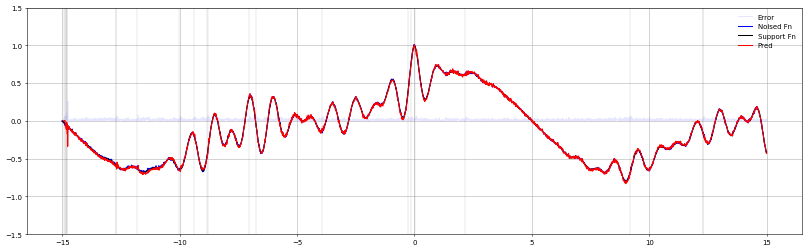

In [79]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import arange, pi

%matplotlib inline 


# function range and actual values
t = arange( -15.0, 15.0, 0.01 )

fnA = np.cos( 2*pi*t ) * np.exp( -1.5*np.abs( np.abs( np.sin( 0.125*pi*t )) ) ) * np.cos( np.abs(t) )
fnB = np.cos( 1.0e-1*pi*t )

# single point of switching mix function (sigmoidal)
mixfnA = 1.0/(1.0+np.exp( -t ))
# multiple alternating switching points (sinusoid) 
mixfnB = (1+np.sin( 0.1*pi*t))/2
# first function ONLY (second function NOT used)
mixfnC = 1-t**0
# second function ONLY (first function NOT used)
mixfnD = t**0

mixfn = mixfnB

fn = (1-mixfn)*fnA + mixfn*fnB



# variance for a normal noise applied to the function
sigma = 1.0e-2
# noised function (normal noise with sigma as specified above)
nfn = fn + sigma*np.random.randn( t.shape[ 0 ], )



# if running in 'adaptive' mode, a sample is used to update the model
# only if the absolute prediction error is above a specified threshold
adaptive = True
errorThreshold = 5.0e-2
# if adaptive mode is 'false' then a percentage of the samples is used
# for training (first percentage * nbSamples, cf. window 'scanner' below)
percentageTraining = 1.0e-1

# response values, actual vs predicted (lresp is for the learnt samples/responses)
resp = []; xresp = []; lresp = [];
# index of the samples that were used as input for learning
lsindx = []



# index and size of the window we will use to scan the data; response offset w.r.t. window
indx = 0; windowSize = 5; respOffset = 1


# number of hidden units (rough ann simulation)
nbHUnits = 10
# initialize a matrix of randow weights (input-hidden layer)
rweights = np.random.randn( windowSize, nbHUnits )
# output weights (that need to be determined, first random)
oweights = np.random.randn( nbHUnits, 1 )



# ann svd for the output layer
annisvd = None



# counters and basic information (time spent training, nb. of samples, etc.)
startt = time.time()

trainingTime = 0
nbTrainingSamples = 0
nbSamples = 0


while indx < t.shape[ 0 ] - (windowSize + respOffset - 1):
    
    hlinp = np.dot( nfn[ indx:windowSize+indx ], rweights )
    hlinp = 1.0/( 1.0 + np.exp( -0.1*hlinp ) ) - 0.5
    
    # store the actual response and calculate the predicted response values
    aresponse = nfn[ indx + (windowSize+respOffset-1) ]
    presponse = np.dot( hlinp.reshape(1,nbHUnits), oweights )
    
    error = np.abs( presponse - aresponse )
    
    xresp = np.append( xresp, presponse )
    resp  = np.append( resp, aresponse )
    
    
    # no svd has been computed up to now, no prediction can be made
    if annisvd == None:
        X = hlinp.reshape( nbHUnits, 1 )
        U, s, Vt = np.linalg.svd( X, full_matrices=False )
        
        annisvd = iSVD( U, s, Vt, updateVt = True  )
        lresp = np.append( lresp, aresponse )
        
    else:
        
        if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold):
            annisvd.update( hlinp.reshape( nbHUnits, 1 ) )
            lresp = np.append( lresp, aresponse )
        
            
    # updating the output weights - note that the update method adds columns
    # and NOT rows (as it would be expected for Ax = y); the incremental SVD
    # we obtain is thus for A^T - we need however the A^+ (pseudoeinverse of A)
    
    # if A^T = UsV^T (SVD) and knowing that i. (A^T)+ = Vs^{-1}U^T; and (ii) (A^+)^T = (A^T)^+
    # we have that (A^+)^T = Vs^{-1}U^T, following that A^+ = Us^{-1}V^T
    
    # in order to upate the weights, we need to calculate x = A^+ y            
    
    if (not adaptive and indx < t.shape[ 0 ] * percentageTraining) or (adaptive and error > errorThreshold) :

        tstart = time.time()
        nbTrainingSamples = nbTrainingSamples+1

        Ux, sx, Vtx = annisvd.svd()

        nzindx = sx > 0; sx[ nzindx ] = 1.0/sx[ nzindx ]
        oweights = np.dot(
            np.dot( Ux, np.dot( np.diag( sx ), Vtx ) ),
            lresp
        )
        tend = time.time()
        trainingTime = trainingTime + (tend-tstart)
        
        lsindx = np.append( lsindx, t[ indx ] )
    
    nbSamples = nbSamples+1
    indx = indx+1

endt = time.time()
    
print( "Nb of samples:", nbSamples, "(", nbTrainingSamples, "samples used for training )" )
print( "Time:", (endt-startt), "(", trainingTime, "for training )" )
print( "RMSE:", ( np.sum((xresp-resp)**2) / resp.shape[ 0 ] )**0.5 )


def axvlines(xs, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = plt.gca().get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = plt.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot


fig = plt.figure( 1, figsize = (20, 6), dpi = 50 )
ax1 = fig.add_subplot( 111 )

ax1.grid( True )
ax1.set_ylim( (-1.5, 1.5) )

axvlines( lsindx, linewidth=0.5, color='gray', alpha=0.5 )

ax1.plot( t[ windowSize+respOffset-1: ], np.abs(resp-xresp), 'blue', label = 'Error', alpha = 0.1)
ax1.plot( t, nfn, 'blue', label = 'Noised Fn' )
ax1.plot( t, fn, 'black', label = 'Support Fn') 
ax1.plot( t[ windowSize+respOffset-1: ], xresp, 'red', label = 'Pred' )

ax1.legend(loc='upper right', frameon=False)

plt.show()